## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

Densenet

at bs=32 only using 1.8GB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from torchvision.models import densenet121
from fastai_extensions import *

In [3]:
torch.cuda.set_device(2)
torch.cuda.current_device()

2

In [4]:
data_dir = Path('data')
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [5]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [6]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [7]:
COUNTRY='colombia'
REGION='borde_rural'
DATASET = f'{COUNTRY}_{REGION}'
DATASET_PATH=colombia_rural
path=data_dir/f'{COUNTRY}_{REGION}/cropped/'
TRAIN_JSON = f'train-{REGION}.geojson'
TEST_JSON = f'test-{REGION}.geojson'

In [8]:
RETRAIN = True
RESIZE_IMAGES = True

In [9]:
MODEL_NAME='cv_reflect_101_ricap'

In [10]:
NB_NUM='06_7_1'

In [11]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 8b96b924, DATE: 20191103


In [12]:
DATE = '20191102'
UID = 'c9c50314'

In [13]:
SUB_NUM='13'

In [14]:
img_size=256
bs=32

In [15]:
train_images=data_dir/f'train/rotated/clipped/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{img_size}'

In [16]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [17]:
df_all.tail()

,id,roof_material,verified,country,region
22548,7a22ddec,healthy_metal,False,st_lucia,gros_islet
22549,7a2f73ea,healthy_metal,False,st_lucia,gros_islet
22550,7a34ffa4,healthy_metal,False,st_lucia,gros_islet
22551,7a41560a,healthy_metal,False,st_lucia,gros_islet
22552,7a283ad0,healthy_metal,False,st_lucia,gros_islet


In [18]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [19]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [20]:
df_all.loc[df_all['id'] == '7a204ec4']

,id,roof_material,verified,country,region
12960,7a204ec4,irregular_metal,True,guatemala,mixco_1_and_ebenezer


In [21]:
len(df_all)

22553

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [22]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [23]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_all, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [24]:
data = (src.transform(tfms, size=128)
        .databunch(bs=bs).normalize(imagenet_stats))

In [25]:
#to check what params object has
#dir(data)

In [26]:
data.label_list

LabelLists;

Train: LabelList (18043 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256

In [27]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

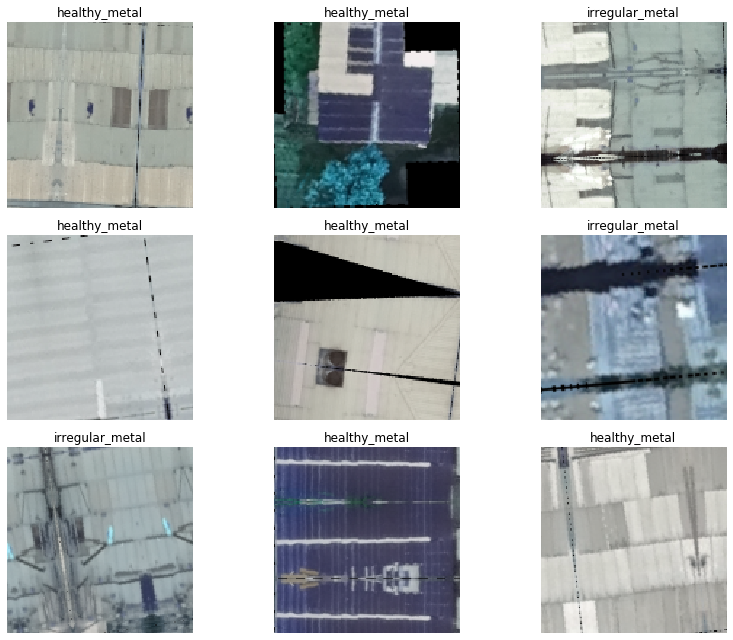

In [28]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [29]:
arch = densenet121
arch_name = 'dn121'

In [30]:
#FP16

In [31]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True).to_fp16().ricap()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


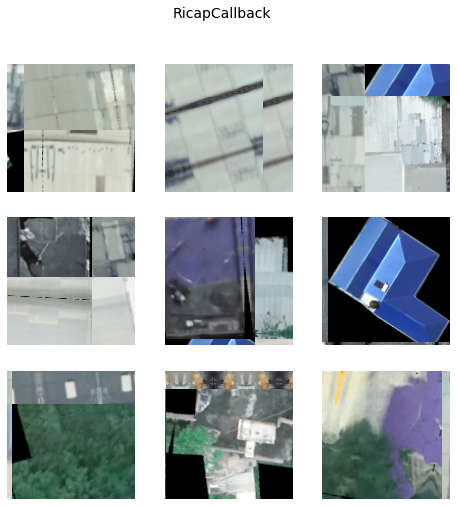

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2,

In [86]:
learn.show_tfms()

We use the LR Finder to pick a good learning rate.

### Train model

In [42]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


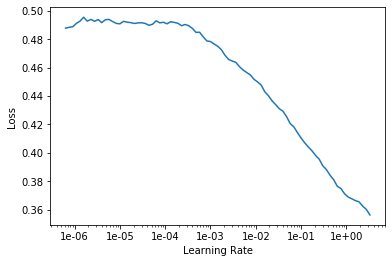

In [43]:
learn.recorder.plot()

Then we can fit the head of our network.

In [47]:
lr = 1e-2

In [48]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.204929,0.548628,0.181375,02:05
1,0.175007,0.474643,0.165410,02:06
2,0.167701,0.455440,0.153880,02:06
3,0.157695,0.430057,0.143459,02:05
4,0.155699,0.429368,0.146785,02:06


In [49]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')
#saves in parent of models directory
#learn.export()

#### Load model

In [87]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2,

In [88]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 290),
 ('healthy_metal', 'irregular_metal', 101),
 ('incomplete', 'irregular_metal', 80),
 ('concrete_cement', 'healthy_metal', 42),
 ('other', 'healthy_metal', 40),
 ('incomplete', 'healthy_metal', 21),
 ('incomplete', 'concrete_cement', 13),
 ('irregular_metal', 'concrete_cement', 13),
 ('concrete_cement', 'incomplete', 12),
 ('concrete_cement', 'irregular_metal', 12),
 ('healthy_metal', 'concrete_cement', 10),
 ('other', 'irregular_metal', 10),
 ('irregular_metal', 'incomplete', 6),
 ('healthy_metal', 'incomplete', 5),
 ('irregular_metal', 'other', 4),
 ('healthy_metal', 'other', 2)]

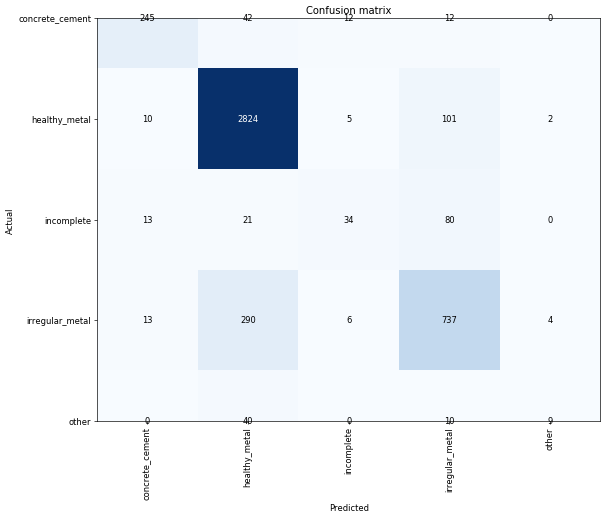

In [89]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [90]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


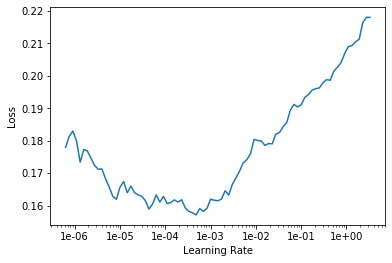

In [91]:
learn.lr_find()
learn.recorder.plot()

In [92]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.154658,0.429148,0.140798,02:29
1,0.155764,0.432607,0.145898,02:29
2,0.155030,0.416913,0.139246,02:30
3,0.150714,0.400445,0.138581,02:30
4,0.145780,0.405742,0.136585,02:30


In [93]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [94]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2,

In [95]:
learn.fit_one_cycle(5, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.145590,0.403111,0.133038,02:30
1,0.151835,0.404489,0.142129,02:31
2,0.149193,0.402720,0.136585,02:30
3,0.144212,0.395159,0.133259,02:30
4,0.139775,0.396125,0.133703,02:31


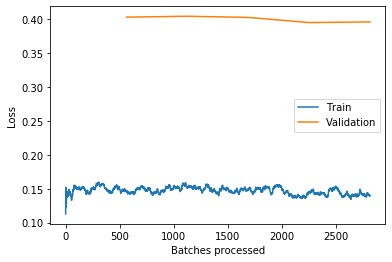

In [96]:
learn.recorder.plot_losses()

In [97]:
learn.save(f'stage-2b-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

### Load model and export for inference

In [32]:
learn.load(f'stage-2b-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')


Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2,

In [33]:
learn = learn.to_fp32()

In [34]:
learn.export()

### inference

In [35]:
test_dataset=ImageList.from_folder(test_images)

In [36]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', test=test_dataset)

In [37]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [38]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [39]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

Get number of items in the Valid dataset (in DeviceDataLoader)

In [40]:
len(learn.dl(DatasetType.Test).dl)

240

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [41]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [42]:
labels = np.argmax(preds, 1)

In [43]:
len(preds)

15325

In [44]:
preds[0].tolist()

[0.19363325834274292,
 0.7720291614532471,
 0.004854197148233652,
 0.027464985847473145,
 0.0020184144377708435]

In [45]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [46]:
len(labels)

15325

In [47]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [48]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [49]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [50]:
test_predictions[0]

'healthy_metal'

In [51]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [52]:
 learn.data.test_ds.x.items

array([PosixPath('data/test/rotated/clipped/256/7a4d9168.tif'),
       PosixPath('data/test/rotated/clipped/256/7a4ae922.tif'),
       PosixPath('data/test/rotated/clipped/256/7a48ca98.tif'),
       PosixPath('data/test/rotated/clipped/256/7a49c614.tif'), ...,
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a468774.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a4b7946.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a4e81f4.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a501f50.tif')], dtype=object)

In [53]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [54]:
preds_list[0]

[0.19363325834274292,
 0.7720291614532471,
 0.004854197148233652,
 0.027464985847473145,
 0.0020184144377708435]

In [55]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [56]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [57]:
df.head()

,id,pred
0,7a4d9168,"[0.19363325834274292, 0.7720291614532471, 0.00..."
1,7a4ae922,"[0.008878495544195175, 0.8894267678260803, 0.0..."
2,7a48ca98,"[0.007859360426664352, 0.3749457597732544, 0.0..."
3,7a49c614,"[0.007671546656638384, 0.9325420260429382, 0.0..."
4,7a4dd4f2,"[0.007635331247001886, 0.8349151611328125, 0.0..."


In [58]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [59]:
pred_df.insert(loc=0, column='id', value=ids)

In [60]:
pred_df.columns = cols

In [61]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.193633,0.772029,0.004854,0.027465,0.002018
1,7a4ae922,0.008878,0.889427,0.003860,0.097135,0.000700
2,7a48ca98,0.007859,0.374946,0.029956,0.582741,0.004498
3,7a49c614,0.007672,0.932542,0.001915,0.055089,0.002782
4,7a4dd4f2,0.007635,0.834915,0.002322,0.088923,0.066204


In [62]:
pred_ids=pred_df['id'].values.tolist()

In [63]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [64]:
baseline_ids=df_baseline['id'].values.tolist()

In [65]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [66]:
pred_df=pred_df.sort_values('id_cat')

In [67]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [68]:
pred_df=pred_df.drop_duplicates(subset=['id'])

In [70]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
8041,7a4d630a,0.014093,0.943532,0.007995,0.031026,0.003354
764,7a4bbbd6,0.005158,0.885602,0.003737,0.103544,0.001958
1841,7a4ac744,0.010756,0.740345,0.009704,0.236804,0.002391
3363,7a4881fa,0.009322,0.294236,0.011498,0.682628,0.002317
7458,7a4aa4a8,0.008782,0.761672,0.014724,0.211142,0.003681


In [69]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

#### Submission result

sub 13: 0.5043

In [74]:
pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

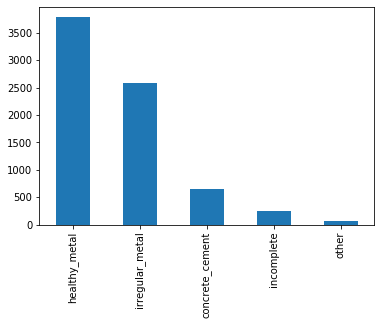

In [75]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")